<a href="https://colab.research.google.com/github/DGkurnia/cnkproject/blob/main/BMLP_Derfansyah_Guswiranata_Kurnia_clus_ii.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Perkenalan diri
## Nama : Derfansyah Guswiranata Kurnia (wira)
## identitas dicoding : dgkurnia
## email dicoding : weerakurnia@gmail.com

# **1. Perkenalan Dataset**


Tahap pertama, Anda harus mencari dan menggunakan dataset **tanpa label** dengan ketentuan sebagai berikut:

1. **Sumber Dataset**:  
   Dataset dapat diperoleh dari berbagai sumber, seperti public repositories (*Kaggle*, *UCI ML Repository*, *Open Data*) atau data primer yang Anda kumpulkan sendiri.
   
2. **Ketentuan Dataset**:
   - **Tanpa label**: Dataset tidak boleh memiliki label atau kelas.
   - **Jumlah Baris**: Minimal 1000 baris untuk memastikan dataset cukup besar untuk analisis yang bermakna.
   - **Tipe Data**: Harus mengandung data **kategorikal** dan **numerikal**.
     - *Kategorikal*: Misalnya jenis kelamin, kategori produk.
     - *Numerikal*: Misalnya usia, pendapatan, harga.

3. **Pembatasan**:  
   Dataset yang sudah digunakan dalam latihan clustering (seperti customer segmentation) tidak boleh digunakan.

In [3]:
#Inisiasi kaggle
!pip install kaggle

In [4]:
#inisiasi file json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"derfansyahgk","key":"24be196f622b75f71753aee422847c5c"}'}

In [5]:
#Penyetelan dataset kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
#Unduh dataset
!kaggle datasets download -d prasad22/weather-data

Dataset URL: https://www.kaggle.com/datasets/prasad22/weather-data
License(s): CC0-1.0
 96% 41.0M/42.6M [00:00<00:00, 69.5MB/s]
100% 42.6M/42.6M [00:00<00:00, 66.6MB/s]


# **2. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [1]:
#Perpustakaan dataset
import numpy as np
import pandas as pd
#Grafik dasar
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#persiapan 'titik sementara' di google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
#persiapan perpustakaan untuk protokol clustering
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
#inspeksi nilai siluet
from sklearn.metrics import silhouette_score
#Persiapan DBSCAN
from sklearn.cluster import DBSCAN
#fitur seleksi di DBSCAN
from sklearn.feature_selection import SelectKBest, f_classif
#Tetangga terdekat
from sklearn.neighbors import NearestNeighbors
#PCA
from sklearn.decomposition import PCA
#optimasi fungsi demi kelanjutan eksekusi
from joblib import Parallel, delayed

In [8]:
#inisiasi 'pelabelan banyak' dan 'identifikasi jarak'
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.spatial import distance

In [9]:
#Visualisasi siluet
from yellowbrick.cluster import SilhouetteVisualizer
import scipy as sp

In [10]:
#Instalasi pyclustering
!pip install pyclustering

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 25.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395099 sha256=935f18491912e0ed612b52c95f0c56b5e32bbce1c25520686de56d61f0ca8299
  Stored in directory: /root/.cache/pip/wheels/b5/42/97/11eee99f5c1e4fdfc170f0a54f9c9eb195df66edb4cf69f449
Successfully built pyclustering


In [11]:
#inisiasi 'dill' untuk serialisasi
! pip install dill
import dill

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 4.2 MB/s eta 0:00:00


In [12]:
#Lanjutan serialisasi
from multiprocessing import Pool
import os #untuk os
import time

# **3. Memuat Dataset**

Pada tahap ini, Anda perlu memuat dataset ke dalam notebook. Jika dataset dalam format CSV, Anda bisa menggunakan pustaka pandas untuk membacanya. Pastikan untuk mengecek beberapa baris awal dataset untuk memahami strukturnya dan memastikan data telah dimuat dengan benar.

Jika dataset berada di Google Drive, pastikan Anda menghubungkan Google Drive ke Colab terlebih dahulu. Setelah dataset berhasil dimuat, langkah berikutnya adalah memeriksa kesesuaian data dan siap untuk dianalisis lebih lanjut.

In [13]:
#Buka zip
!unzip weather-data.zip

Archive:  weather-data.zip
  inflating: weather_data.csv        


In [14]:
#Pembukaan dataset
dfori = pd.read_csv('/content/weather_data.csv') #Data asli
dfcopy = dfori.copy() #Data salinan
#cek sampel
dfcopy.head(7)

,Location,Date_Time,Temperature_C,Humidity_pct,Precipitation_mm,Wind_Speed_kmh
0,San Diego,2024-01-14 21:12:46,10.683001,41.195754,4.020119,8.233540
1,San Diego,2024-05-17 15:22:10,8.734140,58.319107,9.111623,27.715161
2,San Diego,2024-05-11 09:30:59,11.632436,38.820175,4.607511,28.732951
3,Philadelphia,2024-02-26 17:32:39,-8.628976,54.074474,3.183720,26.367303
4,San Antonio,2024-04-29 13:23:51,39.808213,72.899908,9.598282,29.898622
5,San Diego,2024-01-21 08:54:56,27.341055,49.023236,9.166543,27.473896
6,San Jose,2024-01-13 02:10:54,1.881883,65.742325,0.221709,1.073112


In [15]:
#Inisiasi untuk ubah jenis data di tanggal
dfcopy['Date_Time'] = pd.to_datetime(dfcopy['Date_Time']).copy()
#cek jenis data setelah pengubahan
dfcopy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 6 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   Location          1000000 non-null  object        
 1   Date_Time         1000000 non-null  datetime64[ns]
 2   Temperature_C     1000000 non-null  float64       
 3   Humidity_pct      1000000 non-null  float64       
 4   Precipitation_mm  1000000 non-null  float64       
 5   Wind_Speed_kmh    1000000 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 45.8+ MB


In [16]:
#cek jumlah data
deskripsi = dfcopy.describe()
print(deskripsi)

                           Date_Time   Temperature_C    Humidity_pct  \
count                        1000000  1000000.000000  1000000.000000   
mean   2024-03-10 10:40:58.896321792       14.779705       60.021830   
min              2024-01-01 00:00:06      -19.969311       30.000009   
25%    2024-02-04 16:28:23.750000128        2.269631       45.008500   
50%              2024-03-10 11:43:28       14.778002       60.018708   
75%       2024-04-14 03:51:32.500000       27.270489       75.043818   
max              2024-05-18 19:44:10       39.999801       89.999977   
std                              NaN       14.482558       17.324022   

       Precipitation_mm  Wind_Speed_kmh  
count    1000000.000000  1000000.000000  
mean           5.109639       14.997598  
min            0.000009        0.000051  
25%            2.580694        7.490101  
50%            5.109917       14.993777  
75%            7.613750       22.514110  
max           14.971583       29.999973  
std            

# **4. Exploratory Data Analysis (EDA)**

Pada tahap ini, Anda akan melakukan **Exploratory Data Analysis (EDA)** untuk memahami karakteristik dataset. EDA bertujuan untuk:

1. **Memahami Struktur Data**
   - Tinjau jumlah baris dan kolom dalam dataset.  
   - Tinjau jenis data di setiap kolom (numerikal atau kategorikal).

2. **Menangani Data yang Hilang**  
   - Identifikasi dan analisis data yang hilang (*missing values*). Tentukan langkah-langkah yang diperlukan untuk menangani data yang hilang, seperti pengisian atau penghapusan data tersebut.

3. **Analisis Distribusi dan Korelasi**  
   - Analisis distribusi variabel numerik dengan statistik deskriptif dan visualisasi seperti histogram atau boxplot.  
   - Periksa hubungan antara variabel menggunakan matriks korelasi atau scatter plot.

4. **Visualisasi Data**  
   - Buat visualisasi dasar seperti grafik distribusi dan diagram batang untuk variabel kategorikal.  
   - Gunakan heatmap atau pairplot untuk menganalisis korelasi antar variabel.

Tujuan dari EDA adalah untuk memperoleh wawasan awal yang mendalam mengenai data dan menentukan langkah selanjutnya dalam analisis atau pemodelan.

In [21]:
#Inspeksi Grafik Batang (Awal)
ratarata = dfcopy.groupby('Location')[['Temperature_C','Humidity_pct','Precipitation_mm','Wind_Speed_kmh']].mean().reset_index().copy() #Keamanan
ratarata.head(7)

,Location,Temperature_C,Humidity_pct,Precipitation_mm,Wind_Speed_kmh
0,Chicago,15.009208,60.088798,5.003164,14.999501
1,Dallas,15.009097,59.959900,4.997508,15.022001
2,Houston,14.942985,59.967598,4.997757,14.989935
3,Los Angeles,15.081063,60.072151,5.004491,15.035120
4,New York,15.013389,60.044688,4.993057,14.989398
5,Philadelphia,15.035892,60.044902,5.008561,14.990663
6,Phoenix,12.792479,60.048643,6.087485,14.983904


In [22]:
#Inspeksi kolom numerikal
kolnumerik = dfcopy.iloc[:, 2:].copy()
kolnumerik.head(7)

,Temperature_C,Humidity_pct,Precipitation_mm,Wind_Speed_kmh
0,10.683001,41.195754,4.020119,8.233540
1,8.734140,58.319107,9.111623,27.715161
2,11.632436,38.820175,4.607511,28.732951
3,-8.628976,54.074474,3.183720,26.367303
4,39.808213,72.899908,9.598282,29.898622
5,27.341055,49.023236,9.166543,27.473896
6,1.881883,65.742325,0.221709,1.073112


In [23]:
#Inisiasi EDA
kollokasi = dfcopy.iloc[:, 0].copy() #Basis mlb
kollokasi.head(7)

,Location
0,San Diego
1,San Diego
2,San Diego
3,Philadelphia
4,San Antonio
5,San Diego
6,San Jose


In [24]:
#deklarasi panjang kolom numerikal
lenumerik = len(kolnumerik.columns) #Untuk histogram
print(lenumerik)

4


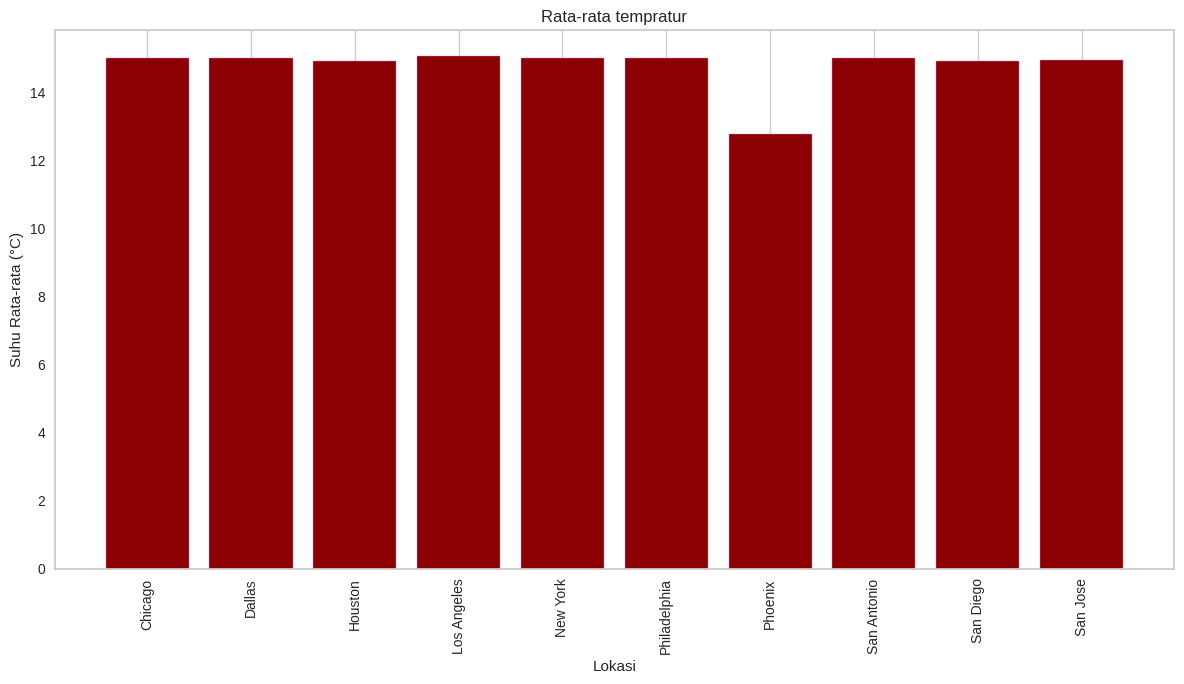

In [29]:
#Cek kelembapan melalui Visualisasi grafik batang (suhu)
plt.figure(figsize=(12, 7))
plt.bar(ratarata['Location'], ratarata['Temperature_C'], color='darkred', edgecolor='violet')
plt.title('Rata-rata tempratur')
plt.xlabel('Lokasi')
plt.ylabel('Suhu Rata-rata (°C)')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()  # Adjust layout to make room for x-axis labels
plt.show()

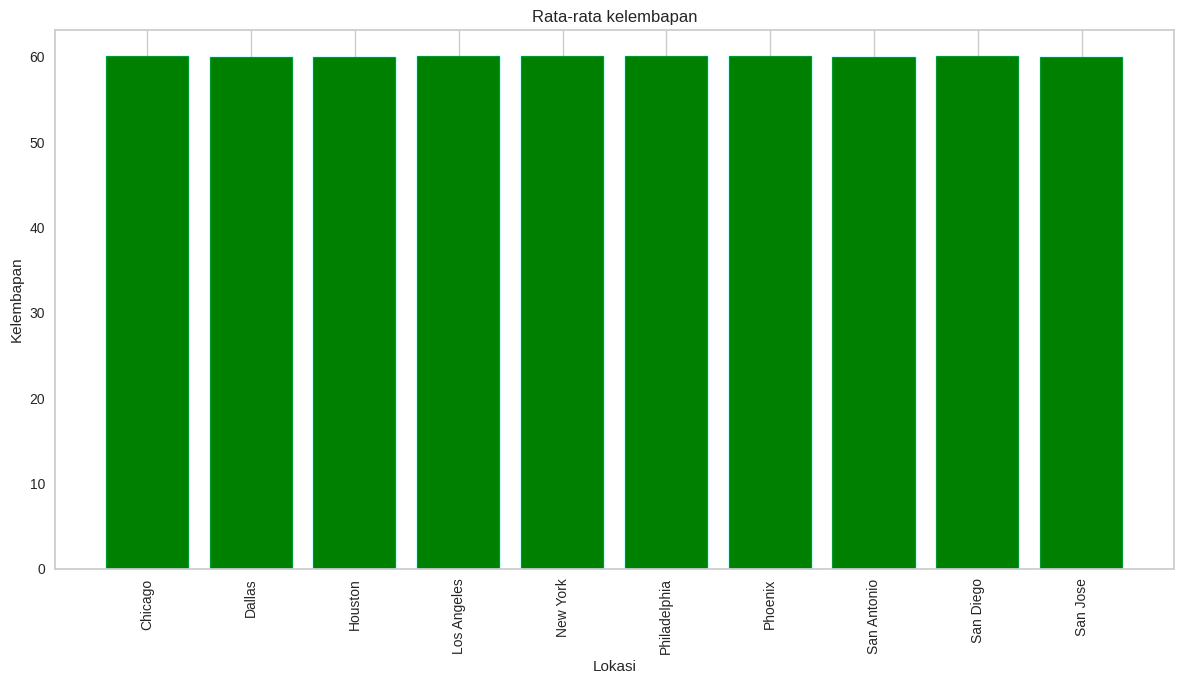

In [28]:
#Visualisasi grafik batang (suhu)
plt.figure(figsize=(12, 7))
plt.bar(ratarata['Location'], ratarata['Humidity_pct'], color='green', edgecolor='cyan')
plt.title('Rata-rata kelembapan')
plt.xlabel('Lokasi')
plt.ylabel('Kelembapan')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()  # Adjust layout to make room for x-axis labels
plt.show()

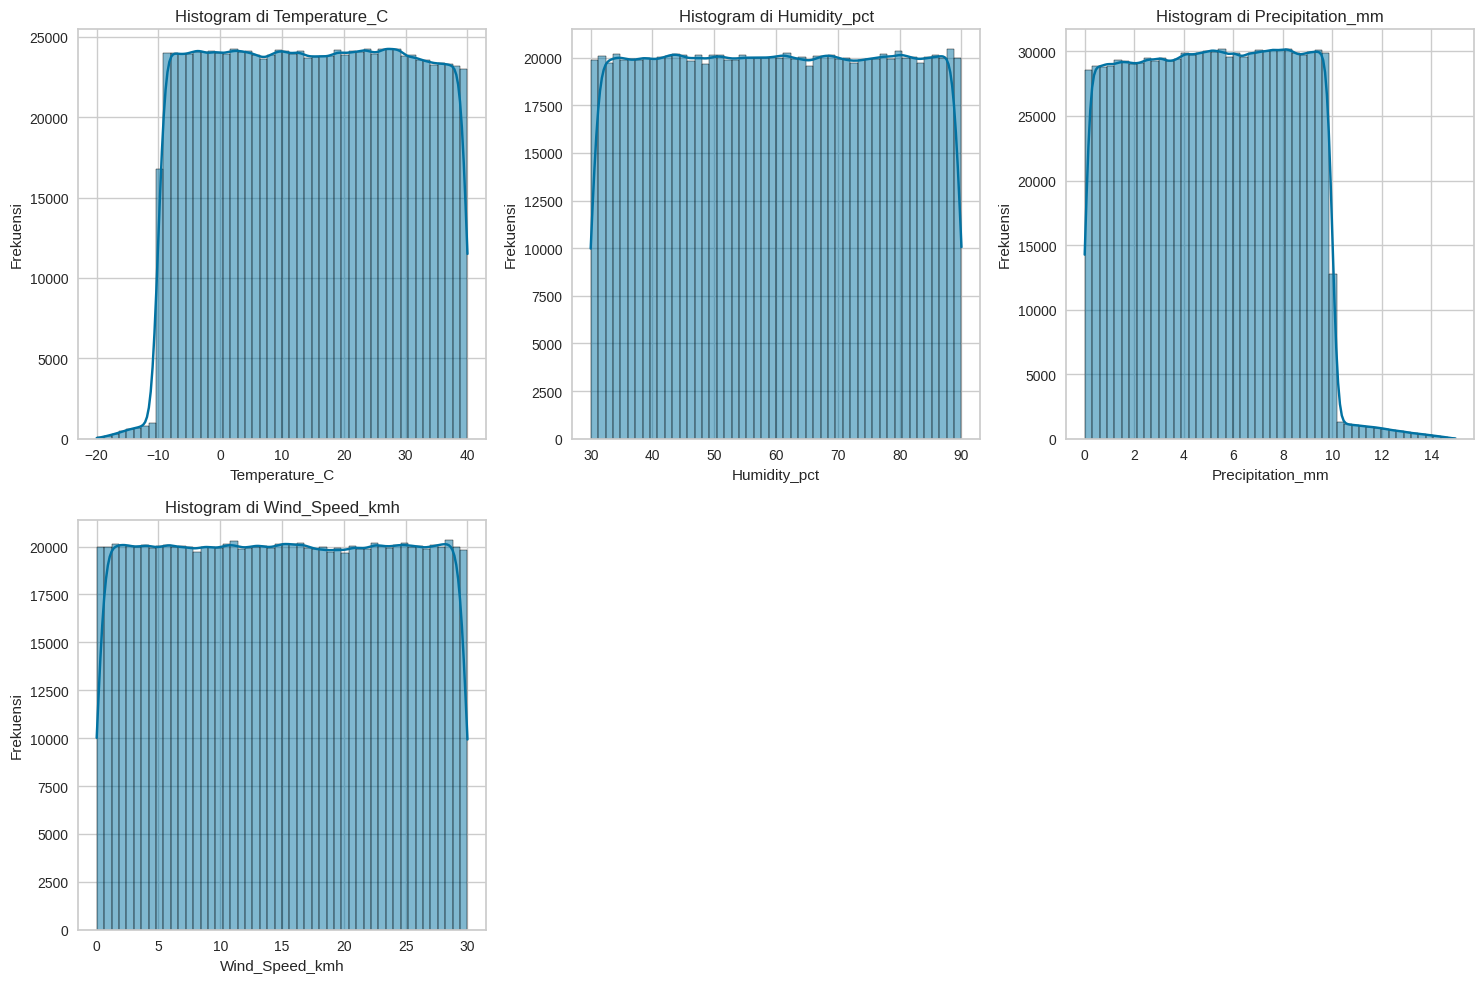

In [27]:
#Histogram untuk pengecekan densitas
totkol = 3 #Kolom
totbar = -(-lenumerik // totkol) #Baris
fig, axes = plt.subplots(totbar, totkol, figsize=(15, totbar * 5))

#Perataan sumbu x
axes = axes.flatten()

for i, column in enumerate(kolnumerik):
    sns.histplot(dfcopy[column], kde=True, bins=50, ax=axes[i])
    axes[i].set_title(f'Histogram di {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frekuensi')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# **5. Data Preprocessing**

Pada tahap ini, data preprocessing adalah langkah penting untuk memastikan kualitas data sebelum digunakan dalam model machine learning. Data mentah sering kali mengandung nilai kosong, duplikasi, atau rentang nilai yang tidak konsisten, yang dapat memengaruhi kinerja model. Oleh karena itu, proses ini bertujuan untuk membersihkan dan mempersiapkan data agar analisis berjalan optimal.

Berikut adalah tahapan-tahapan yang perlu dilakukan, namun **tidak terbatas** pada:
1. Menghapus atau Menangani Data Kosong (Missing Values)
2. Menghapus Data Duplikat
3. Normalisasi atau Standarisasi Fitur
4. Deteksi dan Penanganan Outlier
5. Encoding Data Kategorikal
6. Binning (Pengelompokan Data)

In [30]:
#Inspeksi kolom hilangh
dfcopy.isnull().sum()

,0
Location,0
Date_Time,0
Temperature_C,0
Humidity_pct,0
Precipitation_mm,0
Wind_Speed_kmh,0


In [31]:
#Inspeksi kolom kosong
dfcopy.isna().sum()

,0
Location,0
Date_Time,0
Temperature_C,0
Humidity_pct,0
Precipitation_mm,0
Wind_Speed_kmh,0


Hasil kolom ini dinyatakan bersih

In [32]:
#Penghapusan data duplikat
dfcopy = dfcopy.drop_duplicates().copy()
#lihat hasil
dfcopy.head(7)

,Location,Date_Time,Temperature_C,Humidity_pct,Precipitation_mm,Wind_Speed_kmh
0,San Diego,2024-01-14 21:12:46,10.683001,41.195754,4.020119,8.233540
1,San Diego,2024-05-17 15:22:10,8.734140,58.319107,9.111623,27.715161
2,San Diego,2024-05-11 09:30:59,11.632436,38.820175,4.607511,28.732951
3,Philadelphia,2024-02-26 17:32:39,-8.628976,54.074474,3.183720,26.367303
4,San Antonio,2024-04-29 13:23:51,39.808213,72.899908,9.598282,29.898622
5,San Diego,2024-01-21 08:54:56,27.341055,49.023236,9.166543,27.473896
6,San Jose,2024-01-13 02:10:54,1.881883,65.742325,0.221709,1.073112


In [33]:
#Inspeksi duplikat pasca penghapusan
dfcopy.duplicated().sum()

0

Hasil inspeksi menyatakan kolom sudah bersih

# **6. Pembangunan Model Clustering**

## **a. Pembangunan Model Clustering**

Pada tahap ini, Anda membangun model clustering dengan memilih algoritma yang sesuai untuk mengelompokkan data berdasarkan kesamaan. Berikut adalah **rekomendasi** tahapannya.
1. Pilih algoritma clustering yang sesuai.
2. Latih model dengan data menggunakan algoritma tersebut.

In [34]:
#Basis MLB
lokasi = kollokasi.unique().copy()

In [35]:
#Inisiasi mlb di lokasi
mlb = MultiLabelBinarizer()
#eksekusi mlb di lokasi
mlblok = mlb.fit_transform(kollokasi)
#ke pengubahan ke df

In [36]:
#pengubahan ke df
dfblok = pd.DataFrame(mlblok, columns=mlb.classes_)
#cek hasil
dfblok.head(7)

,,A,C,D,H,J,L,N,P,S,...,l,n,o,p,r,s,t,u,w,x
0,1,0,0,1,0,0,0,0,0,1,...,0,1,1,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,1,...,0,1,1,0,0,0,0,0,0,0
2,1,0,0,1,0,0,0,0,0,1,...,0,1,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,1,0,0,1,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,1,...,0,1,1,0,0,0,1,0,0,0
5,1,0,0,1,0,0,0,0,0,1,...,0,1,1,0,0,0,0,0,0,0
6,1,0,0,0,0,1,0,0,0,1,...,0,1,1,0,0,1,0,0,0,0


Ada 29 kolom dari hasil inspeksi

In [37]:
#Persiapan Robust scaler dan Standard scaler
stdscal = StandardScaler()
rscaler = RobustScaler()
#konversi via robust
hslrobus = rscaler.fit_transform(kolnumerik) #untuk fungsi DBSCAN
#konversi via standard
hslstand = stdscal.fit_transform(kolnumerik) #Inspeksi PCA

Hasil **'standard scaler'** untuk inspeksi PCA

In [38]:
#Penghasilan df numerik
dfhslrobus = pd.DataFrame(hslrobus, columns=kolnumerik.columns) #DBSCAN
dfhslstand = pd.DataFrame(hslstand, columns=kolnumerik.columns) #PCA

In [39]:
#cek hasil (robust)
dfhslrobus.head(7)

,Temperature_C,Humidity_pct,Precipitation_mm,Wind_Speed_kmh
0,-0.163794,-0.626694,-0.216528,-0.449962
1,-0.241746,-0.056587,0.795085,0.846737
2,-0.125818,-0.705787,-0.099821,0.914481
3,-0.936247,-0.197908,-0.382709,0.757023
4,1.001174,0.428868,0.891777,0.992068
5,0.502505,-0.366085,0.805997,0.830678
6,-0.515827,0.190563,-0.971221,-0.926561


In [40]:
#cek hasil std
dfhslstand.head(7)

,Temperature_C,Humidity_pct,Precipitation_mm,Wind_Speed_kmh
0,-0.282872,-1.086704,-0.369580,-0.780749
1,-0.417438,-0.098287,1.357527,1.467939
2,-0.217315,-1.223830,-0.170329,1.585418
3,-1.616337,-0.343301,-0.653298,1.312361
4,1.728184,0.743366,1.522608,1.719967
5,0.867344,-0.634876,1.376157,1.440090
6,-0.890577,0.330206,-1.658052,-1.607249


## **b. Evaluasi Model Clustering**

Untuk menentukan jumlah cluster yang optimal dalam model clustering, Anda dapat menggunakan metode Elbow atau Silhouette Score.

Metode ini membantu kita menemukan jumlah cluster yang memberikan pemisahan terbaik antar kelompok data, sehingga model yang dibangun dapat lebih efektif. Berikut adalah **rekomendasi** tahapannya.
1. Gunakan Silhouette Score dan Elbow Method untuk menentukan jumlah cluster optimal.
2. Hitung Silhouette Score sebagai ukuran kualitas cluster.

In [41]:
#Persiapan df untuk DBSCAN
dfdbscan = pd.concat([dfblok, dfhslrobus], axis=1).copy() #Untuk bahan hasil
#cek hasil
dfdbscan.head(7)

,,A,C,D,H,J,L,N,P,S,...,r,s,t,u,w,x,Temperature_C,Humidity_pct,Precipitation_mm,Wind_Speed_kmh
0,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,-0.163794,-0.626694,-0.216528,-0.449962
1,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,-0.241746,-0.056587,0.795085,0.846737
2,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,-0.125818,-0.705787,-0.099821,0.914481
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,-0.936247,-0.197908,-0.382709,0.757023
4,1,1,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,1.001174,0.428868,0.891777,0.992068
5,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0.502505,-0.366085,0.805997,0.830678
6,1,0,0,0,0,1,0,0,0,1,...,0,1,0,0,0,0,-0.515827,0.190563,-0.971221,-0.926561


In [42]:
#nilai untuk dfdbscan
nildfdbscan = dfdbscan.values

In [43]:
#Fungsi normal untuk DBSCAN
CHECKPOINT_FILE = '/content/drive/My Drive/colab/dbscan_checkpoint.pkl'

def calculate_k_distances(data):
    """Perhitungan epsilon dalam kondisi normal."""
    neighbors = NearestNeighbors(n_neighbors=2)
    neighbors.fit(data)
    distances, _ = neighbors.kneighbors(data)
    return np.sort(distances[:, 1])

def evaluate_dbscan(data, eps, min_samples):
    """Evaluate DBSCAN with given parameters."""
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(data)

    if len(set(labels)) > 1:  # At least two clusters
        return silhouette_score(data, labels), labels
    return -1, None  # Invalid score

def save_checkpoint(best_score, best_params, best_labels):
    """Save the current state to a checkpoint file."""
    with open(CHECKPOINT_FILE, 'wb') as f:
        dill.dump((best_score, best_params, best_labels), f)

def load_checkpoint():
    """Penyimpanan untuk fungsi terakhir."""
    if os.path.exists(CHECKPOINT_FILE):
        with open(CHECKPOINT_FILE, 'rb') as f:
            return dill.load(f)
    return None

def find_optimal_dbscan_params(data, eps_range):
    """Find optimal DBSCAN parameters with checkpointing."""
    distances = calculate_k_distances(data)

    # Penyimpanan hasil
    checkpoint = load_checkpoint()

    best_score = checkpoint[0] if checkpoint else -1
    best_params = checkpoint[1] if checkpoint else (None, None)
    best_labels = checkpoint[2] if checkpoint else None

    total_samples = data.shape[0]
    min_samples_range = range(2, max(2, total_samples // 100))

    start_time = time.time()

    # Parallel evaluation of DBSCAN parameters
    results = Parallel(n_jobs=-1)(
        delayed(evaluate_dbscan)(data, eps, min_samples)
        for min_samples in min_samples_range for eps in eps_range
    )

    # Collect results and check for optimal parameters
    index = 0
    for min_samples in min_samples_range:
        for eps in eps_range:
            score, labels = results[index]
            index += 1

            # Pembaruan skore secara periodik
            if score > best_score:
                best_score = score
                best_params = (eps, min_samples)
                best_labels = labels

            # Checkpoints every hour or when conditions are met
            elapsed_time = time.time() - start_time

            if elapsed_time > 43200:  # 12 hours in seconds
                print("12-hour limit reached. Saving checkpoint...")
                save_checkpoint(best_score, best_params, best_labels)
                return best_params, best_labels

            # Early stopping conditions based on silhouette score
            if best_score >= 0.70:
                print(f"Optimal silhouette score reached: {best_score:.2f} with epsilon: {eps} & min_samples: {min_samples}")
                save_checkpoint(best_score, best_params, best_labels)
                return best_params, best_labels

            elif 0.55 <= best_score < 0.70:
                print(f"Current silhouette score: {best_score:.2f} with epsilon: {eps} & min_samples: {min_samples}")

    save_checkpoint(best_score, best_params, best_labels)  # Final save before completion
    return best_params, best_labels
#Ke persiapan data

In [45]:
#Persiapan data
data = nildfdbscan
eps_range = np.arange(0.01, 1.0, 0.005) #Nilai epsilon
#ke eksekusi sesungguhnya

Aspek visualisasi **'normal'**

In [ ]:
#Eksekusi fungsi
poinminimal = find_optimal_dbscan_params(data, eps_range) #ada dua komponen
#cek hasil
print(f'Optimal eps: {poinminimal[0]}, Optimal minPts: {poinminimal[1]}')

## **c. Feature Selection (Opsional)**

Silakan lakukan feature selection jika Anda membutuhkan optimasi model clustering. Jika Anda menerapkan proses ini, silakan lakukan pemodelan dan evaluasi kembali menggunakan kolom-kolom hasil feature selection. Terakhir, bandingkan hasil performa model sebelum dan sesudah menerapkan feature selection.

In [44]:
#Fungsi dengan 'seleksi fitur'
CHECKPOINT_FILE = '/content/drive/My Drive/colab/dbscan_checkpoint.pkl'  # Penyimpana hasil

def kdistancewsf(data):
    """Calculate optimal k-distance."""
    neighbors = NearestNeighbors(n_neighbors=2)
    neighbors.fit(data)
    distances, _ = neighbors.kneighbors(data)
    return np.sort(distances[:, 1])

def evaluate_dbscan(data, eps, min_samples):
    """Evaluate DBSCAN through feature selection."""
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(data)

    if len(set(labels)) > 1:  # At least two clusters
        return silhouette_score(data, labels), labels
    return -1, None  # No valid clustering found

def feature_selection(data, num_features):
    """Apply ANOVA F-value for best features."""
    selector = SelectKBest(score_func=f_classif, k=num_features)
    selected_data = selector.fit_transform(data[:, :-1], data[:, -1])  # Assuming last column is the target
    return selected_data

def save_checkpoint(best_score, best_params, best_labels, best_feature_count):
    """Save the current state to a checkpoint file."""
    with open(CHECKPOINT_FILE, 'wb') as f:
        dill.dump((best_score, best_params, best_labels, best_feature_count), f)

def load_checkpoint():
    """Load the last saved state from a checkpoint file."""
    if os.path.exists(CHECKPOINT_FILE):
        with open(CHECKPOINT_FILE, 'rb') as f:
            return dill.load(f)
    return None

def cari_nilai_optimal(data, max_features):
    best_feature_count = 0
    best_score = -1
    best_params = (None, None)
    best_labels = None

    # Load previous checkpoint if available
    checkpoint = load_checkpoint()

    if checkpoint:
        best_score, best_params, best_labels, best_feature_count = checkpoint

    # Iterasi hasil
    start_time = time.time()

    for num_features in range(1, max_features + 1):
        selected_data = feature_selection(data, num_features)
        eps_range = np.arange(0.01, 1.0, 0.005)  # Variasi Nilai Epsilon

        total_samples = selected_data.shape[0]
        min_samples_range = range(2, max(2, total_samples // 100))

        # Parallel evaluation of DBSCAN parameters
        results = Parallel(n_jobs=-1)(
            delayed(evaluate_dbscan)(selected_data, eps, min_samples)
            for min_samples in min_samples_range for eps in eps_range
        )

        # Collect results and check for optimal parameters
        index = 0
        for min_samples in min_samples_range:
            for eps in eps_range:
                score, labels = results[index]
                index += 1

                # Update best score and parameters if found a better score
                if score > best_score:
                    best_score = score
                    best_params = (eps, min_samples)
                    best_labels = labels
                    best_feature_count = num_features

                # Checkpoints every hour or when conditions are met
                elapsed_time = time.time() - start_time

                if elapsed_time > 43200:  # 12 hours in seconds
                    print("12-hour limit reached. Saving checkpoint...")
                    save_checkpoint(best_score, best_params, best_labels, best_feature_count)
                    return best_params, best_labels, best_feature_count

                # Early stopping conditions based on silhouette score
                if best_score >= 0.70:
                    print(f"Optimal silhouette score reached: {best_score:.2f} with features: {num_features}; epsilon: {eps}, min_samples: {min_samples}")
                    save_checkpoint(best_score, best_params, best_labels, best_feature_count)
                    return best_params, best_labels, best_feature_count

                elif 0.55 <= best_score < 0.70:
                    print(f"Current optimal range found: {best_score:.2f} with features: {num_features}; epsilon: {eps}, min_samples: {min_samples}")

    save_checkpoint(best_score, best_params, best_labels, best_feature_count)  # Final save before completion
    return best_params, best_labels, best_feature_count

In [46]:
#Persiapan Nilai untuk persiapan data (melalui sf)
datasf = nildfdbscan #untuk veersi sf
#kisaran epsilon
max_features = data.shape[1] - 1 #nilai saat sf

Aspek visualisasi **'hasil seleksi fitur'**

In [ ]:
#Eksekusi hasil dengan "seleksi fitur"
poinminimalsf = cari_nilai_optimal(datasf, max_features) #Eksekusi setelah inspeksi seleksi fitur

In [ ]:
#Penampilan hasil pasca sf (Cek hasil sf)
print(f'Optimal eps: {poinminimalsf[0]}, Optimal minPts: {poinminimalsf[1]}, Optimal number of features: {poinminimalsf[2]}')

## **d. Visualisasi Hasil Clustering**

Setelah model clustering dilatih dan jumlah cluster optimal ditentukan, langkah selanjutnya adalah menampilkan hasil clustering melalui visualisasi.

Berikut adalah **rekomendasi** tahapannya.
1. Tampilkan hasil clustering dalam bentuk visualisasi, seperti grafik scatter plot atau 2D PCA projection.

In [ ]:
#Pemisahan hasil untuk deklarasi normal
bstnparams, blbnparams = poinminimal #Kondisi normal (parameter, label)

In [ ]:
#Hasil dengan "seleksi fitur" (awal pencarian)
numfeatoptimal = poinminimalsf[2] #Unit kedua dari hasil
#seleksi data untuk PCA versi "FS"
datsel = feature_selection(datasf, numfeatoptimal) #Bedakan dengan normal

In [ ]:
#Inisiasi data untuk PCA
pca = PCA(n_components=2)
#Persiapan Visualisasi
principal_components = pca.fit_transform(hslstand) # Untuk visualisasi
#Tahap onversi ke df
dfpca = pd.DataFrame(data=principal_components, columns=['Komponen Prinsip 1', 'Komponen Prinsip 2'])
#Ke persiaoan Kluster

In [ ]:
#Hasil Normal
def visualize_clusters(data, labels):
    """Visualsasi kluster normal."""
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data)

    plt.figure(figsize=(10, 6))

    # Scatter plot of PCA results colored by cluster labels
    unique_labels = set(labels)

    for label in unique_labels:
        if label == -1:  # Point di 'bisikan'
            color = 'k'  # Hitam untuk 'bisikan'
        else:
            lenlabel = len(unique_labels)
            color = plt.cm.jet(label / lenlabel)  # Pewarnaan untuk pembeda

        plt.scatter(reduced_data[labels == label, 0], reduced_data[labels == label, 1], color=color, label=f'Cluster {label}')

    plt.title('Total PCA dari Kluster')
    plt.xlabel('Konsep Prinsip ke 1')
    plt.ylabel('Konsep Prinsip ke 2')

    plt.legend()
    plt.grid()

    plt.show()
    #Eksekusi hasil visualisasi "Normal"
if blbnparams is not None:
    visualize_clusters(data, blbnparams)

In [ ]:
#Pemakaian seleksi fitur
#Persiapan Kluster
if poinminimal[1] is not None:
    dfpca['Cluster'] = poinminimal[1]

# Penggambaran grafik PCA
plt.figure(figsize=(10, 7))
scatter = plt.scatter(dfpca['Komponen Prinsip 1'], dfpca['Komponen Prinsip 2'],
                      c=dfpca['Cluster'], cmap='viridis', alpha=0.6)

# Adding title and labels
plt.title('PCA of Selected Features')
plt.xlabel('Komponen prinsip di PCA (1)')
plt.ylabel('Komponen prinsip di PCA (2)')

# Penambaha Indikator Jika ada kluster
if 'Cluster' in dfpca.columns:
    plt.colorbar(scatter, label='Label Kluster')

plt.grid()
plt.show()

## **e. Analisis dan Interpretasi Hasil Cluster**

Setelah melakukan clustering, langkah selanjutnya adalah menganalisis karakteristik dari masing-masing cluster berdasarkan fitur yang tersedia.

Berikut adalah **rekomendasi** tahapannya.
1. Analisis karakteristik tiap cluster berdasarkan fitur yang tersedia (misalnya, distribusi nilai dalam cluster).
2. Berikan interpretasi: Apakah hasil clustering sesuai dengan ekspektasi dan logika bisnis? Apakah ada pola tertentu yang bisa dimanfaatkan?

In [ ]:
#Type your code here

Tulis hasil interpretasinya di sini.
1. Cluster 1:
2. Cluster 2:
3. Cluster 3:

# **7. Mengeksport Data**

Simpan hasilnya ke dalam file CSV.